In [1]:
%matplotlib inline 
#to generate figures directly in the notebook

# Libraries and Modules
import math 
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
mpl.rcParams['text.usetex'] = True#
mpl.rcParams['text.latex.unicode'] = True#
import numpy as np
from numpy import *
from scipy.integrate import odeint
from scipy.optimize import *

print(mpl.__version__) #check of the matplotlib version

/home/emanuele/venv_research/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


3.0.2


In [2]:
# Parameters and physical constants

h      = 6.62607004e-34   # [J*s]
kb     = 1.38064852e-23   # [J/K]
c      = 299792458        # [m/s]
Na     = 6.02214086e23    # [mol-1]
R      = kb*Na            # 8.314459865590527 [J/(mol*K)]
T      = 293              # [K]
    
C_kJ   = 4184 # 1kCal = 4184 J

print(R*T) #check


2436.1367406180243


In [12]:
# First order rate constants [s-1]

yc = 1 
gf = 1 
gc = 1
yf = 1

um = 10.3*1e-5 #updated wrt version 1 
wm = 1.3*1e-5 #updated wrt version 1 

# Second order rate constants [(s*M)-1]

fp = 4.9*1e-2 
hp = 1.6*1e-2

fm = 0.000000001
wp = 0.000000001

# Rate constants set by thermodynamic constraints
hm = sqrt((hp*fm*yf*hp*fm*gf)/(fp*gc*fp*yc))
up = sqrt((um*yc*wp*um*gc*wp)/(gf*wm*yf*wm))


print('yc   ', yc)
print('gf   ', gf)
print('gc   ', gc)
print('yf   ', yf)
print('fp   ', fp)
print('hp   ', hp)
print('wm   ', wm)
print('um   ', um)
print('fm   ', fm)
print('hm   ', hm)
print('wp   ', wp)
print('up   ', up)

#Chemical potentials differencies:

DGT = -R*T*log(yc/gf) #Std Chem Pot DD - DH
DGT = -R*T*log(gc/yf) #Std Chem Pot HH - HD

muFmuW = R*T*log((fp*wm)/(fm*wp)) #Std chemical potential gradient F-W

DGf = -R*T*log(fp/fm)
DGh = -R*T*log(hp/hm)
DGw = -R*T*log(wp/wm)

print('DGT   ',DGT) 
print('muFmuW    ', muFmuW)

### "standard" kinetic asymmetry
Kr_std  = ((hm+um)**2*yc*(fp+wp)**2*gc/((hp+up)**2*gf*(fm+wm)**2*yf))
print('Kr_std   ', Kr_std)

###  
#print(DGf,DGh,DGw)

### condizione su F per equilibrio

#W0 = 0.000001
#Feq = W0*exp(-muFmuW/(R*T))
#print(Feq)



yc    1
gf    1
gc    1
yf    1
fp    0.049
hp    0.016
wm    1.3000000000000001e-05
um    0.00010300000000000001
fm    1e-09
hm    3.2653061224489796e-10
wp    1e-09
up    7.923076923076924e-09
DGT    -0.0
muFmuW     66214.28307462641
Kr_std    588.6748323348202


In [13]:
def SS_solution(ss,yc,gf,gc,yf,fp,fm,wp,wm,hp,hm,up,um,F0,W0,LM):
    """
    This function takes as input kinetic constants, chemostatted concentrations of F and W, and conserved
    quantity LM. The output is a 6-d array named "ss" containing the stationary state concentrations of the
    internal species.
    """
    
    PH  = ss[0]
    PD  = ss[1]
    DH  = ss[2]
    HD  = ss[3]
    DD  = ss[4]
    HH  = ss[5]
              
    #solo 3 delle 4 equazioni allo stato stazionario sono indipendenti, perché ho una legge di conservazione
              
    H = empty((6))
    H[0] = -(hm+um+fm+wm)*PH + (hp*F0+up*W0)*DH + (fp*F0 + wp*W0)*HH  #PH
    H[1] = -(hm+um+fm+wm)*PD + (hp*F0+up*W0)*HD + (fp*F0 + wp*W0)*DD #PD
    H[2] = -(hp*F0+up*W0+yc)*DH + (hm+um)*PH + gf*DD  #DH
    H[3] = -(hp*F0+up*W0+gc)*HD + (hm+um)*PD + yf*HH  #HD
    H[4] = -(fp*F0+wp*W0+gf)*DD + (fm+wm)*PD + yc*DH  #DD
    H[5] = (PH + PD + DH + HD + DD + HH) - LM #conservation of motor
    return H

## The routine for equilibrium is not strictly needed at the moment
#def EQ_solution(eq,sp,sm,fp,fm,wp,wm,hp,hm,W0,LM):
#    """
#    This function takes as input kinetic constants, chemostatted concentration of W (taken as reference to define
#    the equilibrium distribution), and conserved quantity LM. The output is a 7-d array named "eq" containing the 
#    equilibrium concentrations of the internal species and F given [W] = W0.
#    """
#
#    EPH  = eq[0]
#    EPD  = eq[1]
#    EDH  = eq[2]
#    EHD  = eq[3]
#    EDD  = eq[4]
#    EHH  = eq[5]
#    EF   = eq[6]
#
#    G = empty((7))
#    G[0] =  sp*EDH - sm*EDD #switching 
#    G[1] =  sm*EHD - sp*EHH  #switching
#    G[2] =  fm*EPD - fp*EF*EDD  #fueling
#    G[3] =  wm*EPD - wp*W0*EDD  #wasting
#    G[4] =  fm*EPH - fp*EF*EHH #fueling
#    G[5] =  wm*EPH - wp*W0*EHH #wasting
#    G[6] =  (EPH + EPD + EDH + EHD + EDD + EHH) - LM #conservation of motor
#    return G

def DY_solution(y, t, params):
    """
    This function takes as input kinetic constants, chemostatted concentration of F and W, and conserved quantity 
    LM. The output is the list of rate equations (eq. (1) in the notes) of the kind dy[i]/dt = derivs[i] to
    solve numerically with scipy odeint in order to get the time evolution of concentrations from a certain 
    initial condition up tu a certain time. The conservation of the total amount of motor is "built-in" in writing
    HH as LM minus the sum of all other concentrations.
    """
    PH,PD,DH,HD,DD = y
    yc,gf,gc,yf,fp,fm,wp,wm,hp,hm,up,um,F0,W0,LM = params
    derivs = [-(hm+um+fm+wm)*PH + (hp*F0+up*W0)*DH + (fp*F0 + wp*W0)*(LM - PH -PD -DH - HD -DD), #PH
              -(hm+um+fm+wm)*PD + (hp*F0+up*W0)*HD + (fp*F0 + wp*W0)*DD, #PD
              -(hp*F0+up*W0+yc)*DH + (hm+um)*PH + gf*DD, #DH
              -(hp*F0+up*W0+gc)*HD + (hm+um)*PD + yf*(LM - PH -PD -DH - HD -DD), #HD
              -(fp*F0+wp*W0+gf)*DD + (fm+wm)*PD + yc*DH] #DD
    return derivs

In [17]:
# set the colormap and centre the colorbar
class MidpointNormalize(colors.Normalize):
        """
        Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

        e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
        """
        def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
                self.midpoint = midpoint
                colors.Normalize.__init__(self, vmin, vmax, clip)

        def __call__(self, value, clip=None):
                # I'm ignoring masked values and all kinds of edge cases to make a
                # simple example...
                x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
                return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))


In [14]:
ssGuess = array([0.00001,0.00001,0.0001,0.0001,0.0001,0.0001]); 

F0 = 0.03; W0 = 0.00001  ; LM = 0.01; 
ss = fsolve(SS_solution,ssGuess,args=(yc,gf,gc,yf,fp,fm,wp,wm,hp,hm,up,um,F0,W0,LM))

#affinity/force
aff = R*T*log((fp*wm)/(fm*wp)) + R*T*(log(F0) - log(W0))

#currents
jss = yc*ss[2] - gf*ss[4]
ifuel = F0*(fp*ss[4] + fp*ss[5] + hp*ss[2] + hp*ss[3]) - (fm+hm)*(ss[1] + ss[0])

#work
wch = ifuel*aff

#info
imh = jss*log((ss[2]*ss[3])/(ss[4]*ss[5]))

#energy ratchet
er = jss*log((yc*gc)/(gf*yf))

#efficiency
ncd = R*T*(imh+er)/wch 
      
print(jss)
print(ncd)

3.3252157112957084e-07
2.28019111425369e-05


In [15]:
#definition of lists (where to collect data)
SLP = []; Ratio = [];
FUELINGJ = []; FUELINGEff = []; FUEL = []; INFOFLOW = []; IFJRATIO = [];
AFF = []; PH = []; PD = []; DH = []; HD = []; DD = []; HH = [];
Jf = [] ;Jw  = []; Jh  = []; Ju = []; IW = []; IF = [];
PHe = []; PDe = []; DHe = []; HDe = []; DDe = []; HHe = []; Fe = [];

#Conditions
W0 = 0.00001  ; LM = 0.01

#guess arrays for SS_solution and EQ (needed to initialize the equations solvers)
ssGuess = array([0.0001,0.0001,0.001,0.001,0.001,0.001]); 
#eqGuess = np.array([0.0000001,0.0000001,0.0025,0.0025,0.0025,0.0025, 0.000000000001])


#setting of parameters range (for a np.geomspace, where numbers are spaced evenly on log scale)
sp_min = 1e-5; sp_max = 2e5; 
#rt_min = 1e-2; rt_max = 1e2;
rt_min = 1; rt_max = 1e5;

num = 400;

#loop on the parameters: for each combination of parameters, corresponding steady-state properties are computed
#for F0 in [0.003, 0.03, 0.3, 3]:
for F0 in [0.03]:
    Eff = []; Jt = []; Imh = []; JIF = [] ; FUEL.append(F0) #lits to renew on each cycles and collection of fuel values
    for somma in np.geomspace(sp_min,sp_max,num):
        for r in np.geomspace(rt_min,rt_max,num):
            
            #check for Ben
            ylc = r*somma/(r+1)
            
            ylf = ylc
            glf = ylc/r #sm defined accordingly o r and sp in the loop
            glc = glf
            wlm = wm 
            ulm = um 
            flm = fm 
            flp = fp 
            hlp = hp 
            wlp = wp
            hlm = sqrt((hlp*flm*ylf*hlp*flm*glf)/(flp*glc*flp*ylc))
            ulp = sqrt((ulm*ylc*wlp*ulm*glc*wlp)/(glf*wlm*ylf*wlm))

            
            #call of the routines to solve rate equations
            ss = fsolve(SS_solution,ssGuess,args=(ylc,glf,glc,ylf,flp,flm,wlp,wlm,hlp,hlm,ulp,ulm,F0,W0,LM))
            ssGuess = array([ss[0],ss[1],ss[2],ss[3],ss[4],ss[5]]) 
#            eq = fsolve(EQ_solution,eqGuess,args=(slp,slm,fp,fm,wp,wm,hp,hm,W0,LM))
#            eqGuess = np.array([eq[0], eq[1], eq[2], eq[3], eq[4],eq[5],eq[6]])
            
            #affinity/force
            aff = R*T*log((flp*wlm)/(flm*wlp)) + R*T*(log(F0) - log(W0))
            
            #currents
            jss = ylc*ss[2] - glf*ss[4]
            Jt.append(jss)
            ifuel = F0*(flp*ss[4] + flp*ss[5] + hlp*ss[2] + hlp*ss[3]) - (flm+hlm)*(ss[1] + ss[0])
            JIF.append(jss/ifuel)
            
            #work
            wch = ifuel*aff
            
            #info
            imh = jss*log((ss[2]*ss[3])/(ss[4]*ss[5]))
            Imh.append(imh)
            
            #efficiency
            ncd = R*T*imh/wch
            Eff.append(ncd)
    
    IFJRATIO.append(np.array(JIF))
    FUELINGJ.append(np.array(Jt))
    FUELINGEff.append(np.array(Eff))
    INFOFLOW.append(np.array(Imh))


/home/emanuele/venv_research/lib/python3.6/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


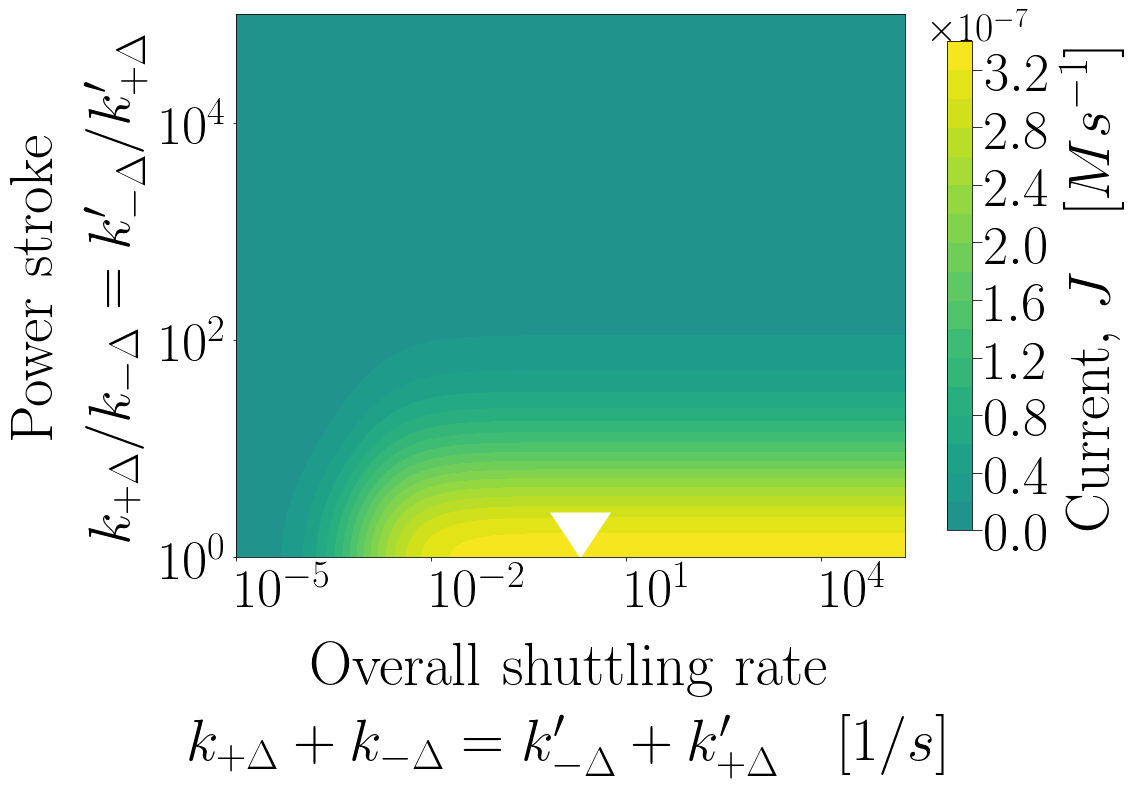

In [21]:
x=np.unique(np.geomspace(sp_min,sp_max,num))
y=np.unique(np.geomspace(rt_min,rt_max,num))


labs = 60 #labelsize
digs = 55 #numbersize

a = len(FUELINGJ)
shuttlingJ, axS = plt.subplots(1, figsize=(15,10), sharex=True)

mid_val = 0.0

#axS[a-1].contourf(x,y,np.array(FUELINGJ[a-1]).reshape(len(y),len(x),order='F'),PAPER_COLORMAP.levels)
im = axS.contourf(x,y,np.array(FUELINGJ).reshape(len(y),len(x),order='F'),20,norm=MidpointNormalize(midpoint=mid_val))

axS.set_xlabel("$\mathrm{Overall \, \, shuttling \, \, rate}$ \n $k_{+\Delta} + k_{-\Delta} = k'_{-\Delta} + k'_{+\Delta} \quad [1/s]$",linespacing=1.5 ,size=labs)
axS.xaxis.set_label_coords(0.5,-0.15)
axS.set_xticklabels(x, ha='left')



axS.contourf(x,y,np.array(FUELINGJ).reshape(len(y),len(x),order='F'),im.levels,norm=MidpointNormalize(midpoint=mid_val))
#axS[i].contourf(x,y,np.array(FUELINGJ[i]).reshape(len(y),len(x),order='F'),PAPER_COLORMAP.levels)

axS.set_xscale('log')
axS.set_yscale('log')
axS.tick_params(axis='x', labelsize=digs)
axS.tick_params(axis='y', labelsize=digs)
axS.set_ylabel("$\mathrm{Power \, \, stroke}$ \n $k_{+\Delta}/k_{-\Delta} = k'_{-\Delta}/k'_{+\Delta}$",linespacing=1.5 , size=labs)
#[axS[j].yaxis.set_label_coords(-0.09,0.5) for j in range(0,a)]
#[axS[j].set_title('$J_\mathrm{ss} \quad for \quad [\mathrm{F}] =$ %s M'%FUEL[j],size=25, pad=10.0)  for j in range(0,a)]
#[axS[j].set_title('$[\mathrm{F}] = %s \; M$'%FUEL[j],size=25, pad=10.0)  for j in range(0,a)]
#[axS.axhline(y=yc/gf, c='#3465A4', linestyle=':') for j in range(0,a)]
#[axS.axvline(x=yc+gf, c='#3465A4', linestyle=':') for j in range(0,a)]

plt.plot(yc+gf,yc/gf, marker=7,markersize=labs,c='w')
#plt.plot(1e4*gf,1e4, marker=5,markersize=labs,c='violet')
#plt.plot(4*gf,3, marker=7,markersize=labs,c='salmon')


cbar= shuttlingJ.colorbar(im, ax=axS, shrink=0.9)
cbar.ax.tick_params(labelsize=digs,length=10)
cbar.ax.yaxis.get_offset_text().set_fontsize(40)
cbar.ax.yaxis.get_offset_text().set_position((3.5,1))
cbar.set_label("$\mathrm{Current}, \, J \quad [Ms^{-1}]$", size=labs, labelpad= 10)


#shuttlingJ.savefig('images/plots4Elisabeth/station_affinity_J.png', dpi=300, bbox_inches='tight')
shuttlingJ.savefig('Ben_ados/images/station_affinity_J_tmp.png', dpi=150, bbox_inches='tight')
#plt.tight_layout()


plt.show()